<style>
th {
  font-size: 14px
}
td {
  font-size: 14px
}
</style>

# Simple tunnel example

This example is available in the following formats.

- pyshop
    - [tunnel_model.py](#tunnel_model.py)
    - [tunnel_gate.py](#tunnel_gate.py)
- YAML
    - [tunnel_model.yaml](#tunnel_model.yaml)
    - [tunnel_gate.yaml](#tunnel_gate.yaml)
- ASCII
    - [tunnel_model.ascii](#tunnel_model.ascii)
    - [tunnel_gate.ascii](#tunnel_gate.ascii)

In [ ]:
#Necessary imports used in all examples
import pandas as pd
import cufflinks as cf
import plotly.offline as py
import plotly.express as px
cf.go_offline()
py.offline.init_notebook_mode(connected=True)
from pyshop import ShopSession

#Functions used in this example for building a tunnel model, adding a gate to a tunnel and running the optimization
from tunnel_model import build_model, add_gate, run_model

ModuleNotFoundError: No module named 'basic_pump'

We create a system with three reservoirs, three tunnels and one plant. In the first model, **shop_default**, there are no gates to optimize, and the flow simply follows the physical laws of the tunnel system. Both the start level and the inflow in Reservoir3, the closest reservoir to the plant, is higher than in the other reservoirs. This means, that some of this extra water in Reservoir3 will naturally flow into the other reservoirs.

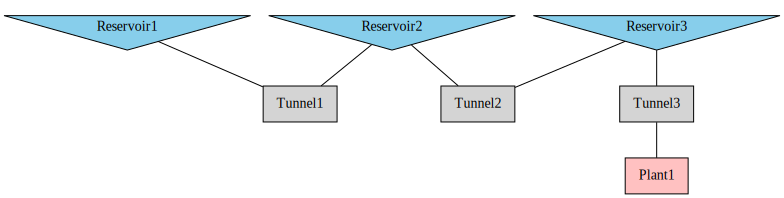

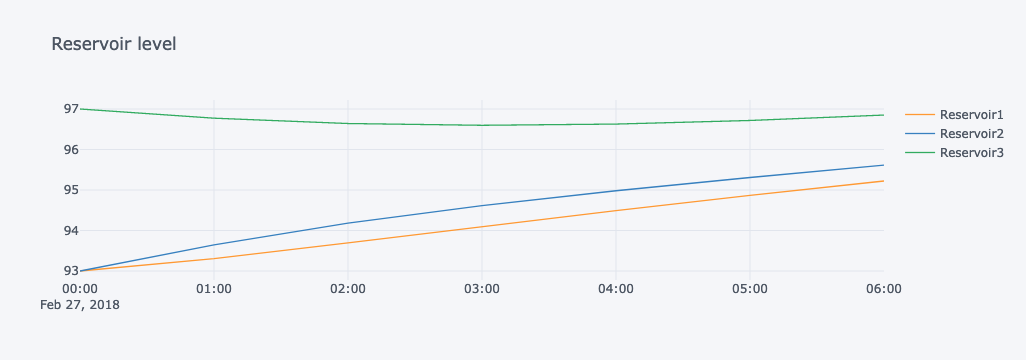

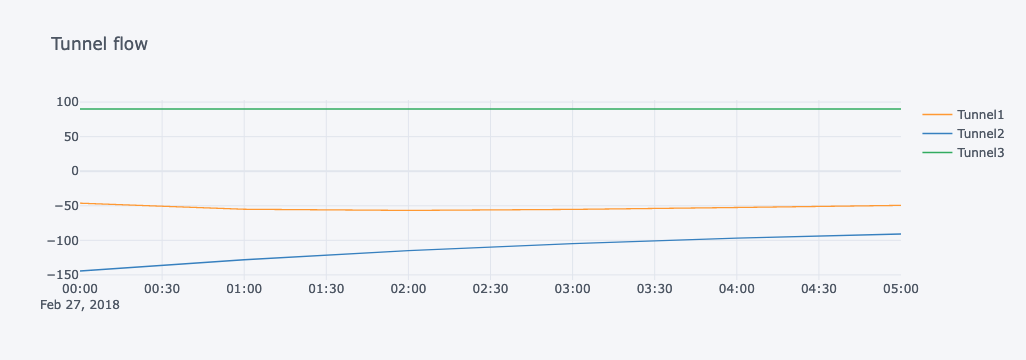

In [2]:
#Create a standard ShopSession
shop_default=ShopSession()
#Build a simple tunnel model without tunnel gates by calling function "build_model" in tunnel_model.py
build_model(shop_default)
#Optimize model by calling "run_model" in tunnel_model.py
run_model(shop_default)
#Display topology to the screen
display(shop_default.model.build_connection_tree())
#Display results for reservoir levels
pd.concat([obj.head.get().rename(obj.get_name()) for obj in shop_default.model.reservoir], axis=1).iplot(title="Reservoir level")
#Display results for tunnel flows
pd.concat([obj.flow.get().rename(obj.get_name()) for obj in shop_default.model.tunnel], axis=1).iplot(title="Tunnel flow")

The second model is allowed to adjust the gate opening in the tunnel between Reservoir2 and Reservoir3. As we see in the results, SHOP is able to keep more water in Reservoir3, and thus get more energy from the plant, by closing this gate for most of the period. Only at the end of the period it is partially opened to prevent spillage from Reservoir3.

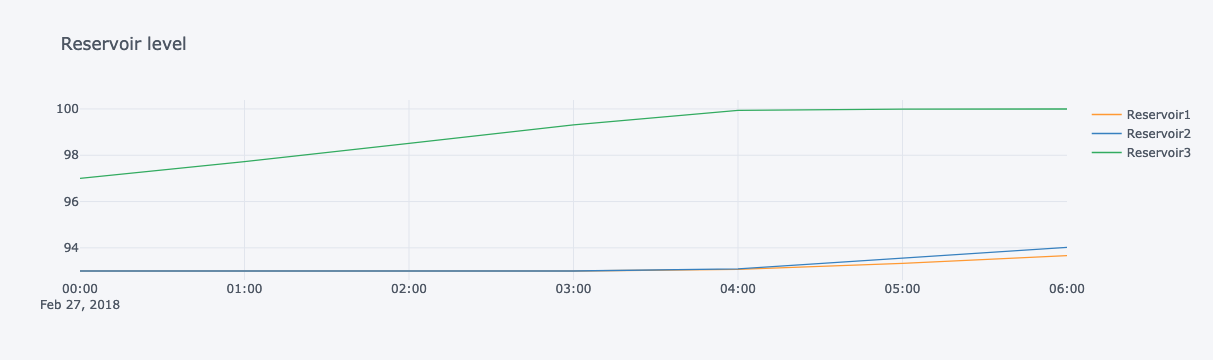

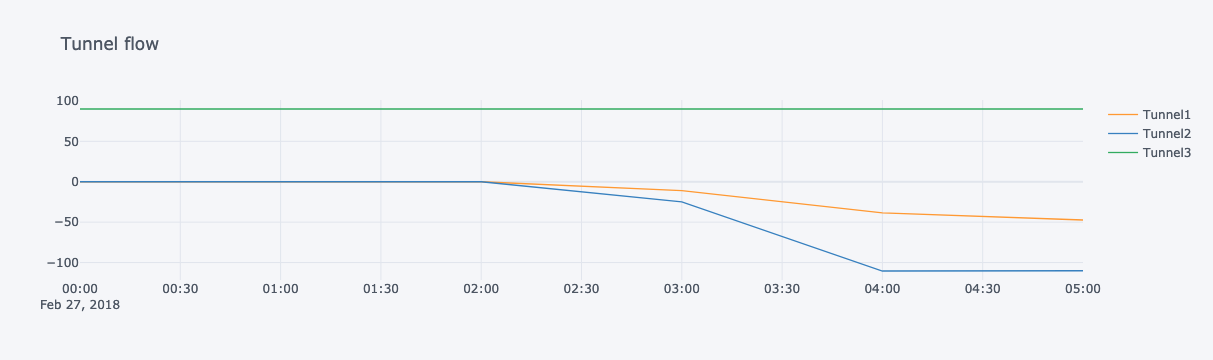

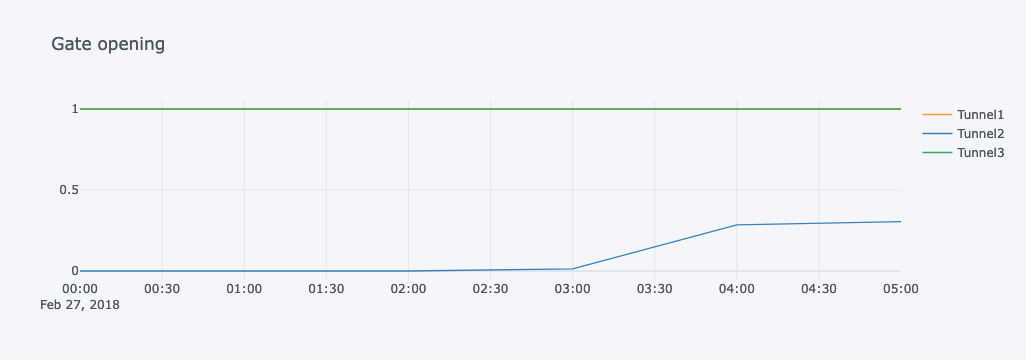

Optimization of the gate in Tunnel2 improved the objective with 665.33€


In [3]:
#Create a standard ShopSession
shop_optimized=ShopSession()
#Build a simple tunnel model without gates by calling function "build_model" in tunnel_model.py
build_model(shop_optimized)
#Add a gate between Reservoir2 and Reservoir3 by calling function "add_gate" in tunnel_model.py
add_gate(shop_optimized)
#Optimize model by calling "run_model" in tunnel_model.py
run_model(shop_optimized)
#Display results for reservoir levels
pd.concat([obj.head.get().rename(obj.get_name()) for obj in shop_optimized.model.reservoir], axis=1).iplot(title="Reservoir level")
#Display results for tunnel flows
pd.concat([obj.flow.get().rename(obj.get_name()) for obj in shop_optimized.model.tunnel], axis=1).iplot(title="Tunnel flow")
#Display results for tunnel opening
pd.concat([obj.gate_opening.get().rename(obj.get_name()) for obj in shop_optimized.model.tunnel], axis=1).iplot(title="Gate opening")

#Compare objective functions to see improvement in result from optimizing the gate
default_objective=shop_default.model.objective["average_objective"].grand_total.get()
optimized_objective=shop_optimized.model.objective["average_objective"].grand_total.get()
print(f"Optimization of the gate in Tunnel2 improved the objective with {-(optimized_objective-default_objective):.2f}€")

# File contents

## tunnel_model.py <a name="tunnel_model.py"></a>

In [4]:
%pycat tunnel_model.py

import pandas as pd

def build_model(shop):
    starttime=pd.Timestamp("2018-02-27 00:00:00")
    endtime=pd.Timestamp("2018-02-27 06:00:00")
    shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit="hour")

    rsv1=shop.model.reservoir.add_object("Reservoir1")
    rsv1.hrl.set(100)
    rsv1.lrl.set(90)
    rsv1.max_vol.set(5)
    rsv1.vol_head.set(pd.Series([90,100,101],index=[0,5,6]))
    rsv1.flow_descr.set(pd.Series([0, 1000], index=[100, 101]))

    rsv2=shop.model.reservoir.add_object("Reservoir2")
    rsv2.hrl.set(100)
    rsv2.lrl.set(90)
    rsv2.max_vol.set(5)
    rsv2.vol_head.set(pd.Series([90,100,101],index=[0,5,6]))
    rsv2.flow_descr.set(pd.Series([0, 1000], index=[100, 101]))

    rsv3=shop.model.reservoir.add_object("Reservoir3")
    rsv3.hrl.set(100)
    rsv3.lrl.set(90)
    rsv3.max_vol.set(5)
    rsv3.vol_head.set(pd.Series([90,100,101],index=[0,5,6]))
    rsv3.flow_descr.set(pd.Series([0, 1000], index=[100, 101]))

    plant1=shop.model.plant.a

## tunnel_gate.py

In [5]:
%pycat tunnel_gate.py

import pandas as pd

def add_tunnel_gate(shop):
    tunnel2=shop.model.tunnel["Tunnel2"]
    tunnel2.gate_opening_curve.set(pd.Series([0,1],index=[0,1]))
    tunnel2.continuous_gate.set(1)


## tunnel_model.yaml <a name="tunnel_model.yaml"></a>

In [6]:
%pycat tunnel_model.yaml

time:
  starttime: 2018-02-27 00:00:00
  endtime: 2018-02-27 06:00:00
  timeunit: hour
  timeresolution:
    2018-02-27 00:00:00: 1
model:
  reservoir:
    Reservoir1:
      start_vol: 0
      start_head: 93
      max_vol: 5
      lrl: 90
      hrl: 100
      vol_head:
        ref: 0
        x:
          - 0
          - 5
          - 6
        y:
          - 90
          - 100
          - 101
      flow_descr:
        ref: 0
        x:
          - 100
          - 101
        y:
          - 0
          - 1000
      endpoint_desc_nok_mwh:
        ref: 0
        x:
          - 0
        y:
          - 31.7
    Reservoir2:
      start_vol: 0
      start_head: 93
      max_vol: 5
      lrl: 90
      hrl: 100
      vol_head:
        ref: 0
        x:
          - 0
          - 5
          - 6
        y:
          - 90
          - 100
          - 101
      flow_descr:
        ref: 0
        x:
          - 100
          - 101
        y:
          - 0
          - 1000
      endpoint_desc_nok_mwh

## tunnel_gate.yaml <a name="tunnel_gate.yaml"></a>

In [7]:
%pycat tunnel_gate.yaml

model:
  tunnel:
    Tunnel2:
      continuous_gate: 1
      gate_opening_curve:
        ref: 0
        x:
          - 0
          - 1
        y:
          - 0
          - 1


## tunnel_model.ascii <a name="tunnel_model.ascii"></a>

In [8]:
%pycat tunnel_model.ascii

OPTIMIZATION time 
#Start_time;   End_time;
20180227000000 20180227060000 

#;N_full_iterations;Accuracy;
OPTIMIZATION   1000       1.00 
#Time resolution in the optimization;
#Id;Number;Start_Time;Time_unit;Period;Data_type;Y_unit;Pts;
     0      0 20180227000000000 HOUR      0     -1 NO_UNIT      7 
#            Time;      f(t);
20180227000000000 1.00000000000000000 

RESERVOIR attributes Reservoir1 
#ID;Water_course;Type;Maxvol;Lrl;Hrl;
     0      0      0      5.000     90.000    100.000 

RESERVOIR vol_head Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
     0      0       0.00      3 MM3 METER
#  x_value;   y_value;
0.0000000000 90.0000000000 
5.0000000000 100.0000000000 
6.0000000000 101.0000000000 

RESERVOIR flow_descr Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
     0      0       0.00      2 METER M3/S
#  x_value;   y_value;
100.0000000000 0.0000000000 
101.0000000000 1000.0000000000 

RESERVOIR endpoint_desc Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
     

## tunnel_gate.ascii <a name="tunnel_gate.ascii"></a>

In [9]:
%pycat tunnel_gate.ascii

TUNNEL gate_positions Tunnel2
#Id;Number;Reference;Pts;X_unit;Y_unit
10600      0      0.000      4 NO_UNIT PERCENT
#  x_value;   y_value;
0 0.0
1 1.0

TUNNEL continuous_gate Tunnel2
1
